# Import Required Libraries


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create Data

In [2]:
def cosine_decision_boundary_function(x: np.ndarray) -> np.ndarray:
    return np.cos(x * math.pi / 5)

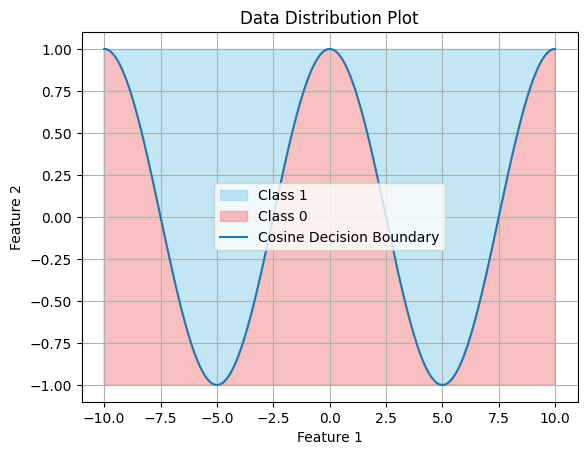

In [3]:
# Generate feature 1 values from -10 to 10
feature_1_values = np.linspace(-10, 10, 400)

# Compute  values using the cosine_decision_boundary_function
decision_boundary_values = cosine_decision_boundary_function(feature_1_values)

# Fill the area above the decision boundary
plt.fill_between(
    feature_1_values,
    decision_boundary_values,
    y2=max(decision_boundary_values),
    where=(decision_boundary_values < max(decision_boundary_values)),
    color="skyblue",
    alpha=0.5,
    label="Class 1",
)

# Fill the area below the decision boundary
plt.fill_between(
    feature_1_values,
    decision_boundary_values,
    y2=min(decision_boundary_values),
    where=(decision_boundary_values > min(decision_boundary_values)),
    color="lightcoral",
    alpha=0.5,
    label="Class 0",
)

plt.plot(feature_1_values, decision_boundary_values, label="Cosine Decision Boundary")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Data Distribution Plot")
plt.legend()
plt.grid(True)

In [4]:
def classifier(X: np.ndarray) -> np.ndarray:
    # Using Sigmoid function for Probability
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    feature_1_values = X[:, 0]
    feature_2_values = X[:, 1]
    decision_boundar_values = cosine_decision_boundary_function(feature_1_values)

    difference = feature_2_values - decision_boundar_values

    classes = np.where(difference > 0, 1, 0)
    predicted_probability = sigmoid(difference)

    return np.array([classes, predicted_probability]).T

In [5]:
# Define the range for x and y
feature_1_lower_bound, feature_1_upper_bound = -10, 10
feature_2_lower_bound, feature_2_upper_bound = -1, 1
n_samples = 1000

# Generate random points within the specified range
feature_1_samples = np.random.uniform(
    feature_1_lower_bound, feature_1_upper_bound, n_samples
)
feature_2_samples = np.random.uniform(
    feature_2_lower_bound, feature_2_upper_bound, n_samples
)

# Create input X for
X = np.array([feature_1_samples, feature_2_samples]).T
output = classifier(X)

X[:5, :], output[:5, :]

(array([[-3.71081667, -0.99096642],
        [ 0.19610856,  0.63823152],
        [-7.51372688, -0.3982068 ],
        [ 5.93884612, -0.53731488],
        [-2.30015536,  0.41690595]]),
 array([[0.        , 0.42519551],
        [0.        , 0.41236754],
        [0.        , 0.3996721 ],
        [1.        , 0.57289793],
        [1.        , 0.57240482]]))

In [6]:
TEST_SIZE = 0.2

In [7]:
X_train, X_test, output_train, output_test = train_test_split(
    X, output, test_size=TEST_SIZE
)
y_train = output_train[:, 0]
y_predicted_probability_train = output_train[:, 1]
y_test = output_test[:, 0]
y_predicted_probability_test = output_test[:, 1]

In [8]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=["Feature 1", "Feature 2"],
    class_names=[0, 1],
    discretize_continuous=False,
)

In [9]:
explanation_instance_idx = 0  #

explanation_instance_X = X_test[explanation_instance_idx, :]
explanation_instance_y = y_test[explanation_instance_idx]
explanation_instance_y_predict_proba = y_predicted_probability_test[explanation_instance_idx]

explanation_instance_X, explanation_instance_y, explanation_instance_y_predict_proba

(array([-4.24977367,  0.51288551]),
 np.float64(1.0),
 np.float64(0.8027905468933265))

In [10]:
exp = explainer.explain_instance(
    explanation_instance_X, explanation_instance_y_predict_proba, num_features=2
)
exp.show_in_notebook(show_table=True, show_all=False)

TypeError: 'numpy.float64' object is not callable